# Visualizing Streaming k-means on IPython + Lightning



<img src="http://lightning-viz.org/images/logo.png" align="left"><br><h1>Lightning</h1>DATA VISUALIZATION SERVER
<br>
<br>

Lightning is a data-visualization server providing API-based access to reproducible, web-based, interactive visualizations. It includes a core set of visualization types, but is built for extendability and customization. Lightning supports modern libraries like d3.js and three.js, and is designed for interactivity over large data sets and continuously updating data streams.  
http://lightning-viz.org  
<br>
API: node.js, Python, Scala  
Extension support for custom chart (eg. d3.js)  
<br>
Lightning requirements:
 - Postgres recommended (SQLlite ok)
 - node.js (npm , gulp)


In [2]:
from IPython.display import IFrame
IFrame('https://lightning-docs.herokuapp.com/visualizations/4/iframe/', 1155, 673)

The Freeman Lab at Janelia Research Campus uses Lightning to visualize large-scale neural recordings from zebrafish, in collaboration with the Ahrens Lab

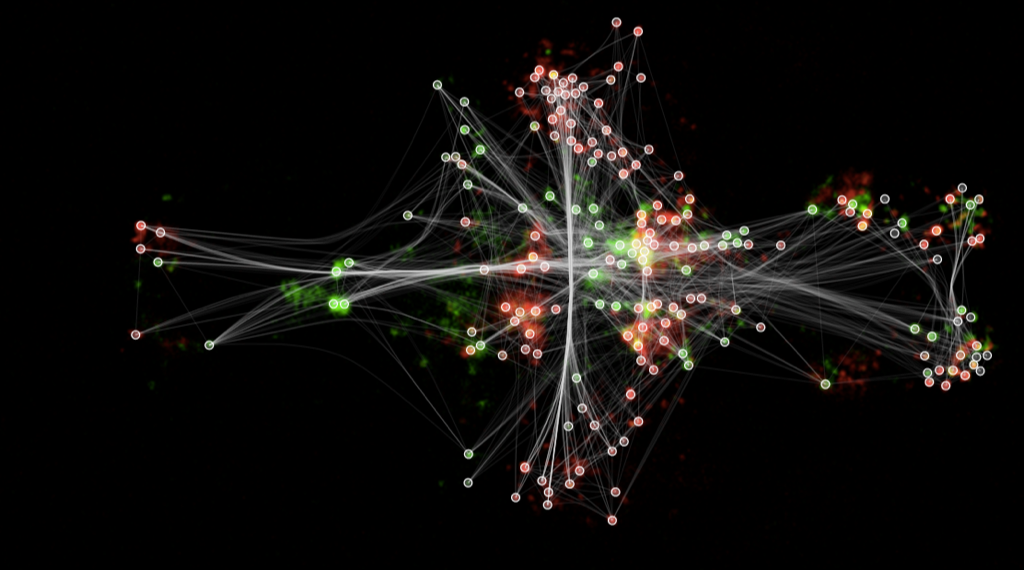

In [3]:
from IPython.display import Image
Image('http://lightning-viz.org/images/featured-graphic.png')

# Let's get started

# Spark Streaming k-means demo
## Environment

 requires: numpy, scipy, scikit-learn  
 IPython/Python requires: lightning-python package

## Demo consists of  3 parts
- Python driver script, data generator
- Scala job - Spark Streaming - Streaming k-means
- IPython client to process result, visualize with Lightning

Originally this was part of the Python driver script - it has been modified for this talk to run within IPython 


### First, some helper functions

In [6]:
import os
import glob
from numpy import loadtxt
from StringIO import StringIO

def loadrecent(filename, oldtime, oldoutput):
    try:
        fname = max(glob.iglob(filename), key=os.path.getctime)
    except:
        #print('No file found')
        return [], oldtime

    newtime = os.path.getctime(fname)
    if not (newtime > oldtime):
        #print('File is not new')
        return oldoutput, oldtime

    try:
        f = open(fname)
        if os.fstat(f.fileno()).st_size == 0:
            print('File is empty')
            return [], oldtime
    except:
        print('Cannot load file')
        return [], oldtime

    prediction = loadtxt(fname, delimiter=',')
    return prediction, newtime

def readcenters(i):
    """ Read integer labels """
    #print (os.path.join(datainlabels, 'labels%g.txt' % i))
    try:
        centers = loadtxt(os.path.join(datainlabels, 'labels%g.txt' % i), dtype=int)
    except:
        print('Cannot load cluster membership labels', sys.exc_info())
        return array([])

    return centers
    
def readpts(i):
    """ Read original points """
    try:
        with open (os.path.join(datain, 'batch%g.txt' % i), 'r') as ptsfile:
            ptscontent=ptsfile.read().replace('[', '').replace(']', '')

        pts = loadtxt(StringIO(ptscontent), delimiter=',')
    except:
        print('Cannot load points', sys.exc_info())
        return array([])

    return pts
        

### Processing k-means model
##### 1. read model computed by Spark Streaming k-means
##### 2. compute results with numpy
##### 3. add to Lightning's streaming viz, displaying it as an iFrame in IPython

In [7]:

import time
from numpy import asarray, array, vstack, hstack, size, random, argsort, ones, argmin, sin, cos, pi
from IPython.display import display, IFrame, HTML

def run(dataout, nbatches, ncenters, ndims, lgn=None, npoints = 50):
        viz = None
        modeltime = 0
        model = []

        # loop over batches
        for i in range(1, nbatches):
            time.sleep(1)

            # get the latest model (after waiting)
            oldtime = modeltime
            model, modeltime = loadrecent(dataout + '/*-model.txt', modeltime, model)

            # plot an update (if we got a valid model)
            if len(model) == ncenters:

                    if (oldtime != modeltime):
                        centers = readcenters(i)
                        pts = readpts(i)
                        
                    # pts.size should == len(pts) * 2
                    if (len(centers) == npoints & len(pts) == npoints):

                        clrs = centers
                        order = argsort(centers)
                        clrs = clrs[order]
                        pts = pts[order]
                        s = ones(npoints) * 10

                        if ndims == 1:
                            pts = vstack((pts, model[:,None]))
                        else:
                            pts = vstack((pts, model))
                        clrs = hstack((clrs, ones(ncenters) * 5))
                        s = hstack((s, ones(ncenters) * 10))

                        # wait a few iterations before plotting
                        if (i > 5):

                            # scatter plot for two dimensions
                            if ndims == 2:
                                if viz is None:
                                    viz = lgn.scatterstreaming(pts[:, 0], pts[:, 1], label=clrs, size=s)
                                    display(IFrame(viz.get_permalink(), width=1280, height=1280))
                                else:
                                    viz.append(pts[:, 0], pts[:, 1], label=clrs, size=s)

                            # line plot for one dimension
                            elif ndims == 1:
                                if viz is None:
                                    viz = lgn.linestreaming(pts, label=clrs, size=s/2)
                                    display(IFrame(viz.get_permalink(), width=1280, height=1280))
                                else:
                                    viz.append(pts, label=clrs, size=s/2)
                                    
                            else:
                                raise Exception('Plotting only supported with 1 or 2 dimensions')


### Now, let's create the Lightning session and kick start the loop above
#### To run,
##### - ensure the Lightning server is running
##### - start the Python driver script and wait 2-3 seconds for it to clean up the input/output data directory
##### - then execute the cell below 

In [ ]:
import os
import tempfile
from lightning import Lightning

ncenters = 4 # 9
ndims = 2 # 1
nbatches = 100  # nb 100, 40
lightninghost = 'http://192.168.128.1:3000'

path = os.path.join(tempfile.gettempdir(), 'streamkmeans')
dataout = os.path.join(path, 'output')
datain = os.path.join(path, 'input')
datainlabels = os.path.join(path, 'inputlbl')

lgn = Lightning(lightninghost) #, ipython=True)
lgn.create_session('streaming-kmeans')
run(dataout, nbatches, ncenters, ndims, lgn)
